In [1]:
!pip install nltk
!pip install pandas
!pip install pymorphy2
!pip install gensim
!pip install tqdm
!pip install spacy
!pip install pandarallel
!python -m spacy download ru_core_news_sm 
!pip install pickle
import os
wlist_path="wlist.pkl"
seg_file_path = 'seg_word_arr.pkl'
lemm_words_path='lemm_words_data.csv'

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 15.3/15.3 MB 3.0 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


C:\Users\Антон\AppData\Roaming\Python\Python310\site-packages\cupy\_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [2]:
import seaborn as sns
from os import walk
import os, os.path
import numpy as np
import time
import json
import spacy
import nltk
import re
import pickle
from nltk.corpus import stopwords
import pymorphy2
m = pymorphy2.MorphAnalyzer()
from gensim.corpora import Dictionary
from gensim.models import TfidfModel,Word2Vec
import pandas as pd
from gensim import similarities
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from gensim.models import TfidfModel, lsimodel
from gensim.utils import simple_preprocess
os.getenv("SENTENCE_TRANSFORMERS_HOME")

C:\Users\Антон\AppData\Roaming\Python\Python310\site-packages\cupy\_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


'C:\\ProgramData\\python_data'

In [3]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [4]:
tqdm.pandas()

In [5]:
nlp = spacy.load("ru_core_news_sm")

In [6]:
MIN_WORD_COUNT=3

In [7]:
import torch
print(torch.cuda.is_available())

True


In [8]:
nltk.download("stopwords")
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Антон\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
data=pd.read_csv("clean_dataset.csv")

In [10]:
Y=data[['cat']]
X=data[['text']]
X

,text
0,научно исследовательский геологический институ...
1,совет депутатов муниципального округа останки...
2,официальный сайт поселения сосенское г. москв...
3,сайт городского округа щербинка города москвы...
4,администрация поселения щаповское в городе мос...
...,...
7952,аукционный дом знакъ. мы предлагаем избранные ...
7953,нумизматический интернет аукцион золотникъ. по...
7954,аукцион почтовых марок. покупка почтовых марок.
7955,торги по банкротству агрегатор торгов ефрсб то...


In [11]:
lemm_cache={}
text_data={}
wlist={}

#код лемматизации
seg_word_arr={}
seg_item_arr={}
def lemm(w):
    if (w in lemm_cache):
        return lemm_cache[w]
    else:
        nw=m.parse(w)[0].normal_form
        lemm_cache[w]=nw
        return nw
    


In [12]:

from nltk.tokenize import word_tokenize
def nltk_tokenizer(s):
    return s

def nltk_filter(tokens):
        # Также лемматизация nltk
    proc_tokens=[token for token in tokens if token not in russian_stopwords]
    
    return proc_tokens

def lemm_filter(text):
    doc = nlp(text)
    
    # Лемматизация и фильтрация (удаляем предлоги и союзы по тегам POS)
    filtered_tokens = nltk_filter([token.lemma_ for token in doc if token.pos_ not in ["ADP", "CCONJ", "SCONJ"]])


    
    return ' '.join(filtered_tokens)

def filter_replacer(text):
    symbols=['<','>','“','{','}','”',
             '$','#',",",".",":","!","?",
             '#','&',"/","\"","'",'▲','▼','®','‘','™','®','“','[',']','$','(',')','%','©','←','>','\\','·']
    proc_text=text
    for symbol in symbols:
        proc_text=proc_text.replace(symbol,"")
    
    proc_text=proc_text.replace(" — "," ")
    proc_text=proc_text.replace(" - "," ")
    proc_text=proc_text.replace("о́",'о')
    proc_text=proc_text.replace("ы́",'ы')
    proc_text=proc_text.replace("и́",'и')
    return proc_text.split(" ")

#Создадим вектор из лемматизированных описаний сайтов
def l_word_arr(row):

    w_arr=[]

    text=filter_replacer(row['text'])
    doc = nlp(' '.join(text))
    filtered_tokens = nltk_filter([token.lemma_ for token in doc if token.pos_ not in ["ADP", "CCONJ", "SCONJ"]])

    joined_filters=' '.join(filtered_tokens)
    
    t_arr=filter_replacer(joined_filters)
    len_arr=len(t_arr)
    if (len_arr in seg_word_arr):
        seg_word_arr[len_arr]+=1
    else:
        seg_word_arr[len_arr]=1
    for item in t_arr:
        if (len(item.strip())>0):
            lem_word=lemm(item)
            if lem_word not in wlist:
                wlist[lem_word]=1
            else:
                wlist[lem_word]+=1
            w_arr.append(lem_word)
    return w_arr

def l_word_split(row):


    filtered_tokens=lemm_filter(" ".join(nltk_tokenizer(row['text_split'])))
    
    joined_filters=' '.join(filtered_tokens)
    t_arr=filter_replacer(joined_filters)
    new_words=[]
    for item in t_arr:
        lem_word=lemm(item)
        new_words.append(lem_word)
    return " ".join(new_words)


# Функция для удаления повторяющихся слов в строке
def remove_duplicates(text):
    words = text.split()  # Разбиваем текст на слова
    unique_words = list(dict.fromkeys(words))  # Убираем дубликаты, сохраняя порядок
    return ' '.join(unique_words)  # Соединяем слова обратно в строку

In [13]:
def l_word_str_join(row):
    return " ".join(row['lemm_words'])

In [14]:
#data['lemm_words']=data.progress_apply(l_word_arr,axis=1) #progress_apply


if False:
    # Если файл существует, загружаем колонку из файла
    lemm_words = pd.read_csv(lemm_words_path, usecols=['lemm_words'])
    data['lemm_words'] = lemm_words
    print("Колонка загружена из файла.")
    if os.path.exists(wlist_path):
        with open(wlist_path, 'rb') as file:
            wlist=pickle.load(file)
    if os.path.exists(seg_file_path):
        with open(seg_file_path, 'rb') as file:
            seg_word_arr=pickle.load(file)
else:

    data['lemm_words']=data.progress_apply(l_word_arr,axis=1) #progress_apply
    print("Колонка создана.")

    data[['lemm_words']].to_csv(lemm_words_path, index=False)
    print("Колонка сохранена в файл.")
    with open(wlist_path, 'wb') as file:
        pickle.dump(wlist, file)
    with open(seg_file_path, 'wb') as file:
        pickle.dump(seg_word_arr, file)
    print("Словарь сохранен в файл.")

100%|██████████████████████████████████████████████████████████████████████████████| 7957/7957 [03:26<00:00, 38.51it/s]


Колонка создана.
Колонка сохранена в файл.
Словарь сохранен в файл.


In [15]:
data['lemm_words']

0       [научно, исследовательский, геологический, инс...
1       [совет, депутат, муниципальный, округ, останки...
2       [официальный, сайт, поселение, сосенский, г, м...
3       [сайт, городской, округ, щербинка, город, моск...
4       [администрация, поселение, щаповский, город, м...
                              ...                        
7952    [аукционный, дом, знакъ, предлагать, избрать, ...
7953    [нумизматический, интернет, аукцион, золотникъ...
7954    [аукцион, почтовый, марк, покупка, почтовый, м...
7955    [торг, банкротство, агрегатор, торг, ефрсб, то...
7956    [фонд, развитие, территория, один, основный, м...
Name: lemm_words, Length: 7957, dtype: object

In [16]:
data['lemm_words_str']=data.progress_apply(l_word_str_join,axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 7957/7957 [00:00<00:00, 162387.67it/s]


In [17]:
#data['lemm_words_str'] = data['lemm_words_str'].progress_apply(remove_duplicates) #Удаление дубликатов
data['lemm_words_str']

0       научно исследовательский геологический институ...
1       совет депутат муниципальный округ останкинский...
2       официальный сайт поселение сосенский г москва ...
3       сайт городской округ щербинка город москва нов...
4       администрация поселение щаповский город москва...
                              ...                        
7952    аукционный дом знакъ предлагать избрать вещь и...
7953    нумизматический интернет аукцион золотникъ пок...
7954          аукцион почтовый марк покупка почтовый марк
7955    торг банкротство агрегатор торг ефрсб торг рос...
7956    фонд развитие территория один основный механиз...
Name: lemm_words_str, Length: 7957, dtype: object

In [18]:
#проанализируем данные. Узнаем информацию о количестве слов и размере словаря.

print("Размер словаря:"+str(len(wlist.keys()))+" слов")

Размер словаря:43985 слов


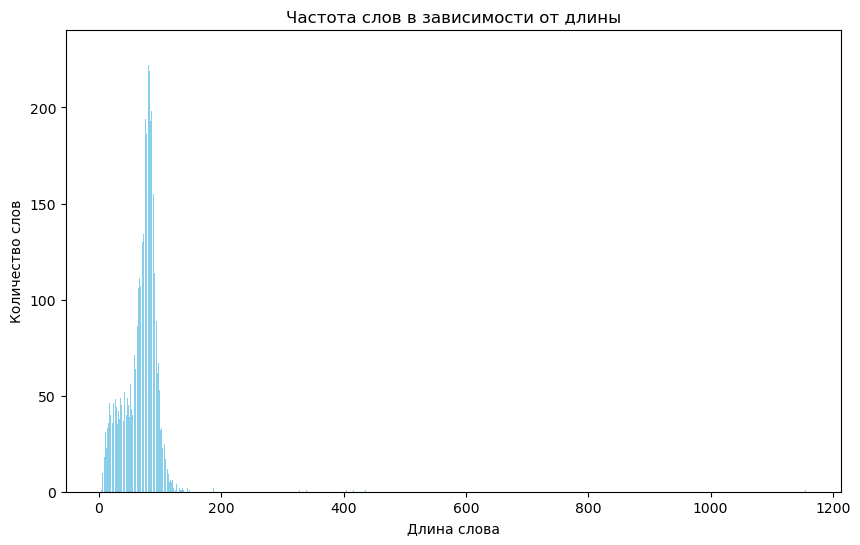

In [19]:
import matplotlib.pyplot as plt
#Построим гистограмму по количеству слов в предложениях
# Получение ключей и значений из словаря
lengths = list(seg_word_arr.keys())
frequencies = list(seg_word_arr.values())

# Построение графика
plt.figure(figsize=(10, 6))
plt.bar(lengths, frequencies, color='skyblue')

# Добавление заголовка и меток осей
plt.title('Частота слов в зависимости от длины')
plt.xlabel('Длина слова')
plt.ylabel('Количество слов')

# Отображение графика
plt.show()

<BarContainer object of 112 artists>

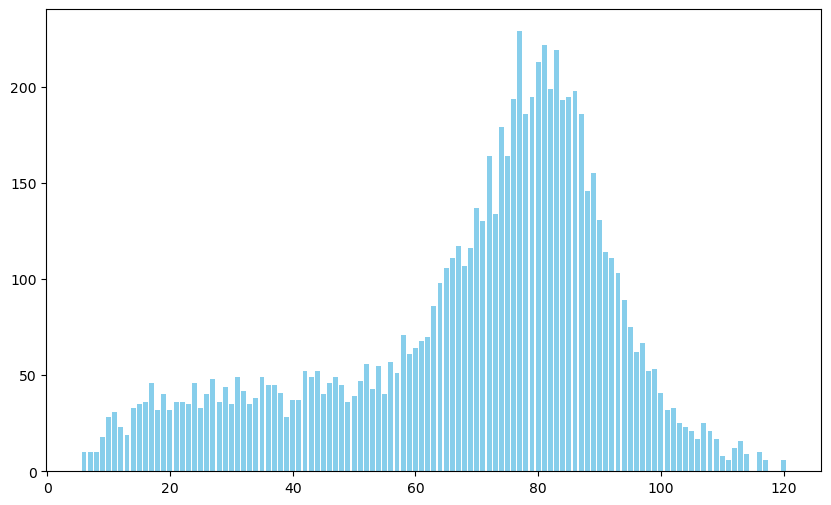

In [20]:
new_seg={k: v for k, v in seg_word_arr.items() if v>5}
lengths = list(new_seg.keys())
frequencies = list(new_seg.values())

plt.figure(figsize=(10, 6))
plt.bar(lengths, frequencies, color='skyblue')

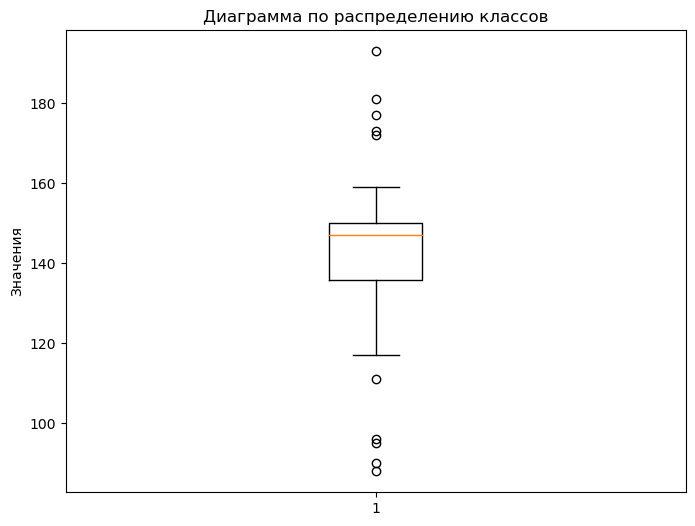

In [21]:
# Подсчёт частоты каждого класса

class_counts = data['cat'].value_counts().reset_index()
class_counts.columns = ['cat', 'count']
class_counts
# Построение диаграммы с усами

plt.figure(figsize=(8, 6))


plt.boxplot(x=class_counts['count'])

# Настройка осей и заголовка
plt.title('Диаграмма по распределению классов')

plt.ylabel('Значения')

# Отображение диаграммы
plt.show()

In [22]:
def text_split_func():
    data=data.groupby('cat').tail(1000)
    data
    data['text_split'] = data['text'].str.split('.')

    data=data.explode('text_split')

    data = data.reset_index(drop=True)
    data['text_split']=data.progress_apply(l_word_split,axis=1)
    
#text_split_func()
sorted_d=data.sort_values('cat')
#sorted_d['l']=sorted_d['text_split'].replace(",","").replace("  "," ").str.split(' ').map(len)
sorted_d['lsent']=sorted_d['lemm_words_str'].replace(",","").replace("  "," ").str.split(' ').map(len)
sorted_d

,Unnamed: 0,source,text,cat,lemm_words,lemm_words_str,lsent
5643,5643,bandeatos.ru,"доставка еды по приморскому району, васильевс...",2101,"[доставка, еда, приморский, район, васильевски...",доставка еда приморский район васильевский ост...,91
5640,5640,1001eda.com,еда простые вкусные рецепты с фото. проверенны...,2101,"[еда, простой, вкусный, рецепт, фото, проверит...",еда простой вкусный рецепт фото проверить кули...,75
5641,5641,barakat24.ru,чайхона баракат доставка еды на дом и в офис и...,2101,"[чайхон, баракат, доставка, еда, дом, офис, се...",чайхон баракат доставка еда дом офис сеть рест...,14
5642,5642,cafesandal.ru,"кафе сандал. ресторан, банкетный зал, кафе ч...",2101,"[кафе, сандал, ресторан, банкетный, зал, кафе,...",кафе сандал ресторан банкетный зал кафе чистый...,77
5644,5644,hlebtver.ru,"купить хлеб оптом, производство и продажа хле...",2101,"[купить, хлеб, опт, производство, продажа, хле...",купить хлеб опт производство продажа хлеб хлеб...,88
...,...,...,...,...,...,...,...
2650,2650,mirchild.narod.ru,"раннее развитие ребенка, обзор анализ методик...",21205,"[ранний, развитие, ребёнок, обзор, анализ, мет...",ранний развитие ребёнок обзор анализ методика ...,74
2651,2651,barabashkaclub.ru,главная барабашка. барабашка. от метро тушинск...,21205,"[главный, барабашка, барабашка, метро, тушинск...",главный барабашка барабашка метро тушинский ма...,18
2652,2652,babyhelp.kiev.ua,babyhelp в помощь родителям. в помощь родителя...,21205,"[babyhelp, помощь, родитель, помощь, родитель,...",babyhelp помощь родитель помощь родитель свежи...,29
2636,2636,phdinparenting.com,phd в родительстве phd в воспитании детей. во...,21205,"[phd, родительство, phd, воспитание, ребёнок, ...",phd родительство phd воспитание ребёнок воспит...,59


In [23]:
sorted_d[6250:6355]

,Unnamed: 0,source,text,cat,lemm_words,lemm_words_str,lsent
2879,2879,expoweb.ru,справочник организаций города москвы. отзывы....,21101,"[справочник, организация, город, москва, отзыв...",справочник организация город москва отзыв com ...,73
2880,2880,fb2book.net,скачать книги формате fb txt бесплатно. скача...,21101,"[скачать, книга, формат, fb, txt, бесплатно, с...",скачать книга формат fb txt бесплатно скачать ...,64
2881,2881,fileext.info,fileext база данных расширений файлов. поиск ...,21101,"[fileext, база, данные, расширение, файл, поис...",fileext база данные расширение файл поиск расш...,23
2882,2882,file-extension.info,расширение файла. информация поможет вам решит...,21101,"[расширение, файл, информация, помочь, решить,...",расширение файл информация помочь решить основ...,52
2883,2883,flamp.ru,фламп лучшие компании москвы по отзывам клиен...,21101,"[флампа, хороший, компания, москва, отзыв, кли...",флампа хороший компания москва отзыв клиент ре...,72
...,...,...,...,...,...,...,...
7229,7229,eqworld.ipmnet.ru,математические уравнения eqworld. мир математи...,21102,"[математический, уравнение, eqworld, мир, мате...",математический уравнение eqworld мир математич...,76
7249,7249,единыйурок.рф,педагогические программы повышения квалификаци...,21102,"[педагогический, программа, повышение, квалифи...",педагогический программа повышение квалификаци...,93
7230,7230,ideas4el.ru,идеи для уроков английского идеи для уроков а...,21102,"[идея, урок, английский, идея, урок, английски...",идея урок английский идея урок английский пред...,46
7232,7232,virtulab.net,виртуальная физика биология химия экология вир...,21102,"[виртуальный, физика, биология, химия, экологи...",виртуальный физика биология химия экология вир...,90


In [24]:
print(sorted_d.loc[100]['text'])
print("  \\")
print(sorted_d.loc[100]['lemm_words_str'])

управление образования андроповского района. мероприятия,  конкурсы ,  фестивали,  соревнования. воспитательная работа и дополнительное образование. творческие конкурсы и мероприятия. профилактика детского дорожно транспортного травматизма. профилактика употребления наркотических и психоактивных веществ. дадим шанс детям. защита жилищных прав детей. независимая оценка качества образовательной деятельности. комплектование библиотечного фонда. документы по проверкам образовательных организаций. муниципальная система оценки качества образования. реализация майских указов президента россии. телефоны горячей линии по вопросам заработной платы. единое расписание егэ,  огэ,  гвэ. горячая линия гиа. есть предложения по организации учебного процесса или знаете,  как сделать школу лучше. всероссийская олимпиада школьников. телефоны горячей линии по вопросам приёма граждан на обучение по образовательным программам.
  \
управление образование андроповский район мероприятие конкурс фестиваль соревн

In [25]:
#Преобразуем категории в число от 0 до n
def convert_categories_to_n(df, cat_column='cat'):
    # Получаем уникальные категории и создаем словарь для маппинга
    unique_categories = df[cat_column].unique()
    category_mapping = {cat: idx for idx, cat in enumerate(unique_categories)}
    
    # Создаем новую колонку 'cat_n', используя маппинг
    df['cat_n'] = df[cat_column].map(category_mapping)
    
    return df

sorted_d=convert_categories_to_n(sorted_d)
mapping_dict = dict(sorted_d[['cat_n', 'cat']].drop_duplicates().values)
sorted_d

,Unnamed: 0,source,text,cat,lemm_words,lemm_words_str,lsent,cat_n
5643,5643,bandeatos.ru,"доставка еды по приморскому району, васильевс...",2101,"[доставка, еда, приморский, район, васильевски...",доставка еда приморский район васильевский ост...,91,0
5640,5640,1001eda.com,еда простые вкусные рецепты с фото. проверенны...,2101,"[еда, простой, вкусный, рецепт, фото, проверит...",еда простой вкусный рецепт фото проверить кули...,75,0
5641,5641,barakat24.ru,чайхона баракат доставка еды на дом и в офис и...,2101,"[чайхон, баракат, доставка, еда, дом, офис, се...",чайхон баракат доставка еда дом офис сеть рест...,14,0
5642,5642,cafesandal.ru,"кафе сандал. ресторан, банкетный зал, кафе ч...",2101,"[кафе, сандал, ресторан, банкетный, зал, кафе,...",кафе сандал ресторан банкетный зал кафе чистый...,77,0
5644,5644,hlebtver.ru,"купить хлеб оптом, производство и продажа хле...",2101,"[купить, хлеб, опт, производство, продажа, хле...",купить хлеб опт производство продажа хлеб хлеб...,88,0
...,...,...,...,...,...,...,...,...
2650,2650,mirchild.narod.ru,"раннее развитие ребенка, обзор анализ методик...",21205,"[ранний, развитие, ребёнок, обзор, анализ, мет...",ранний развитие ребёнок обзор анализ методика ...,74,55
2651,2651,barabashkaclub.ru,главная барабашка. барабашка. от метро тушинск...,21205,"[главный, барабашка, барабашка, метро, тушинск...",главный барабашка барабашка метро тушинский ма...,18,55
2652,2652,babyhelp.kiev.ua,babyhelp в помощь родителям. в помощь родителя...,21205,"[babyhelp, помощь, родитель, помощь, родитель,...",babyhelp помощь родитель помощь родитель свежи...,29,55
2636,2636,phdinparenting.com,phd в родительстве phd в воспитании детей. во...,21205,"[phd, родительство, phd, воспитание, ребёнок, ...",phd родительство phd воспитание ребёнок воспит...,59,55


In [26]:
#mapping_dict

In [27]:
np.array(sorted_d[['lemm_words_str']][7000:8000])

array([['переводчик онлайн экспертный языковой решение любой размер бизнес профессиональный переводчик языковой пара сервис онлайн перевод узнать перевод самый популярный языковой пара удовлетворить клиент получать своевременный ответ перевести родный язык com являться лидер рынок профессиональный перевод локализация программный обеспечение передовой языковой услуга штаб квартира афтоня сша доверить ведущий предприятие компания весь мир наш компания помогать клиент добиться успех международный рынок помощь качественный инструмент талантливый человек переводить большой количество контент многий область общий бизнес текст который требовать знание эксперт отраслевой экспертиза'],
       ['pons словарь определение перевод словарь немецкий самый надёжный словарь инстранный язык включаеть материал изучение язык определение пример произношение словарный тренер онлайн словарь pons правописание немецкий язык бесплатный словарный онлайн тренажёр pons мочь сообщить ошибка дать статья pons com обы

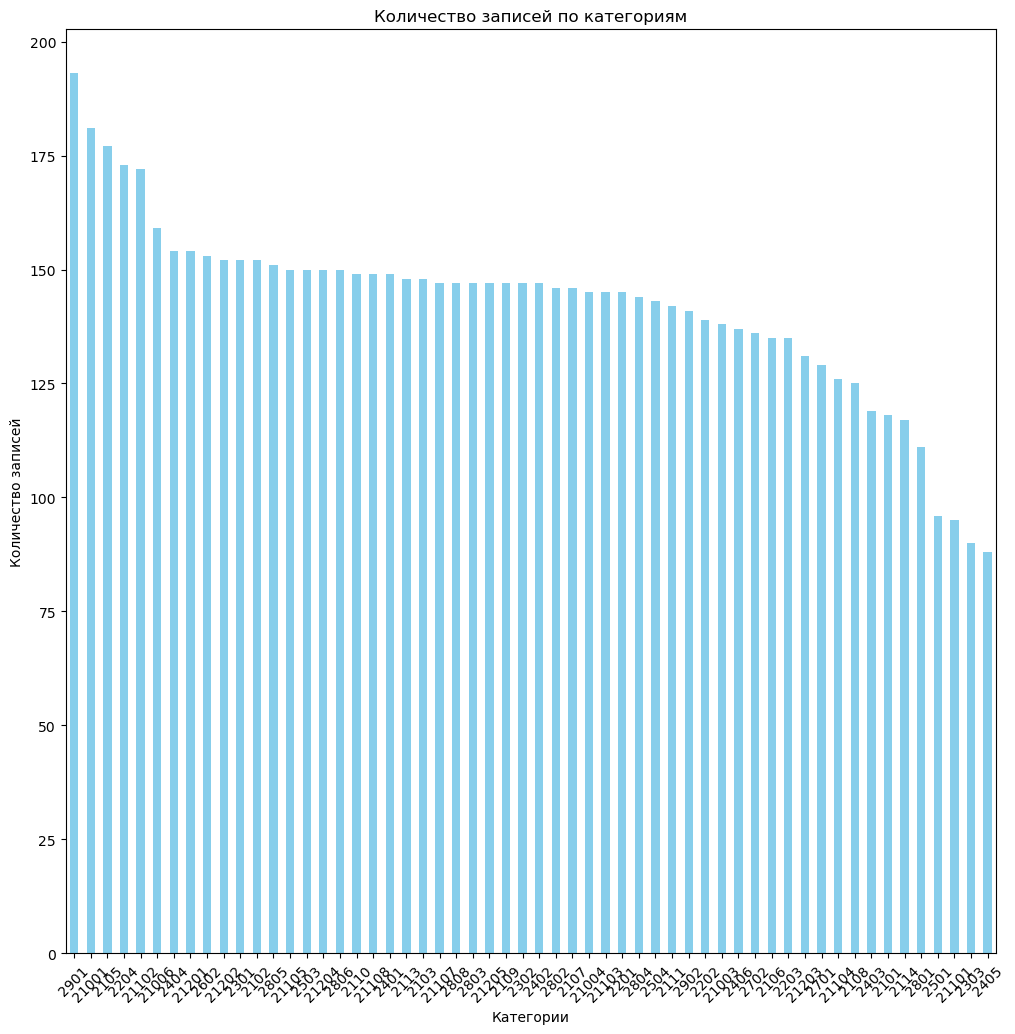

In [28]:
# Подсчет количества записей по категориям
category_counts = sorted_d['cat'].value_counts()

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 12))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Количество записей по категориям')
plt.xlabel('Категории')
plt.ylabel('Количество записей')
plt.xticks(rotation=45)
plt.show()

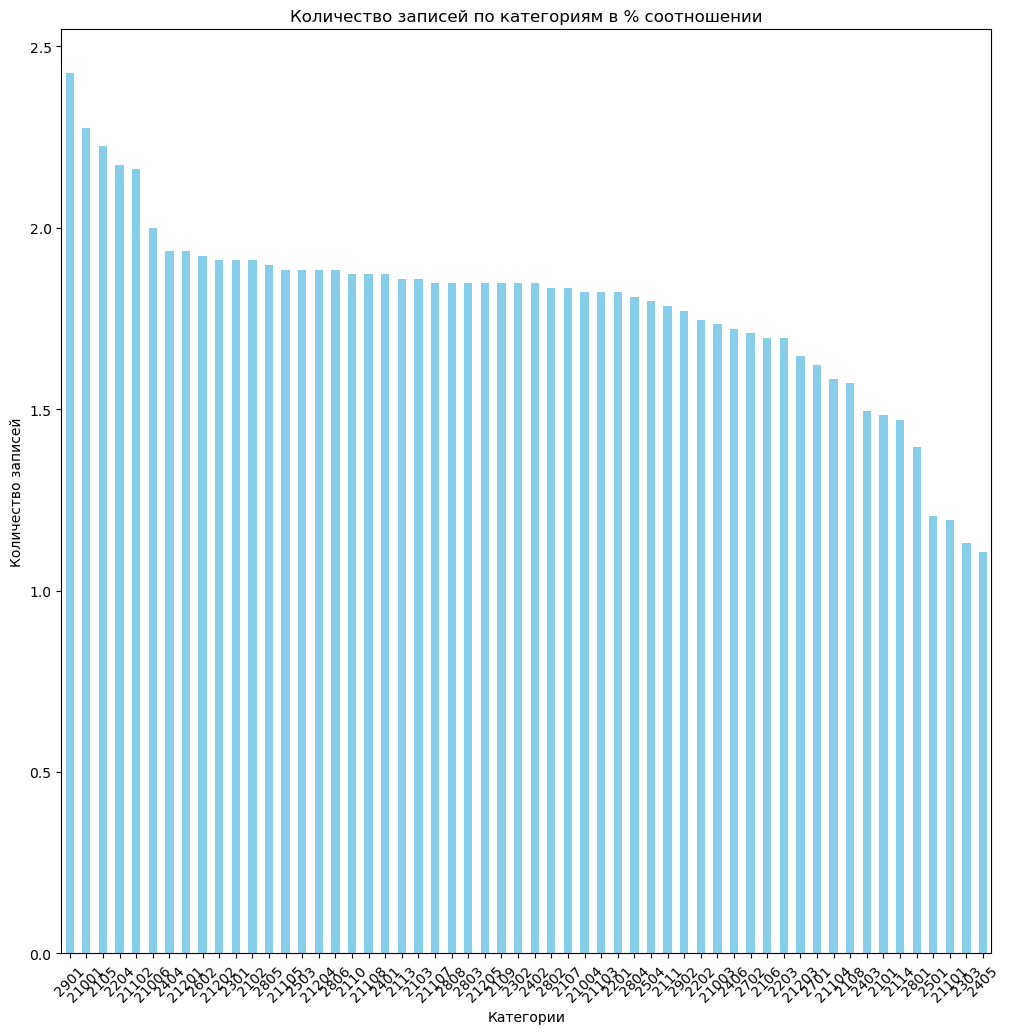

In [29]:
# Подсчет количества записей по категориям в %
category_counts = sorted_d['cat'].value_counts()/7957.0*100;

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 12))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Количество записей по категориям в % соотношении')
plt.xlabel('Категории')
plt.ylabel('Количество записей')
plt.xticks(rotation=45)
plt.show()

In [30]:
value_counts = sorted_d['lsent'].value_counts()
# Построение графика
#value_counts.plot(kind='bar',figsize=(16,8))

In [31]:
VECTOR_SIZE=768
LEARN_EPOCHS=300
HIDDEN_SIZE=4096
SENTENCE_COUNT=8000 # 2000 was ok
TRAIN_EPOCHS=6000


In [32]:
import torch
import torch.nn.functional as F
import pandas as pd
from gensim.models import Word2Vec
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split



In [33]:
from transformers import DistilBertModel, DistilBertTokenizer
from torch.utils.data import DataLoader
# Загружаем предобученную модель DistilBERT и токенизатор
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

texts = sorted_d['lemm_words_str'].tolist()  # Лемматизированные тексты


C:\Users\Антон\AppData\Roaming\Python\Python310\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [34]:
from datasets import Dataset


# Разбиение на обучающую и тестовую выборки
#mlm_train_test_split = tokenized_dataset.train_test_split(test_size=0.1)
#mlm_train_test_split

In [35]:
#mlm_train_dataset = mlm_train_test_split['train']
#mlm_eval_dataset = mlm_train_test_split['test']

In [36]:
# Преобразование DataFrame в numpy массивы
datass = {col: sorted_d[col].values for col in sorted_d.columns}

# Сохранение в формате .npz
np.savez('dataframe.npz', **datass)

In [33]:
from transformers import DistilBertTokenizer, DistilBertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments
import torch.optim as optim
model_path = './fine_tuned_distilbert_mlm'
#mlm_model = DistilBertForMaskedLM.from_pretrained('distilbert-base-multilingual-cased')
mlm_model = DistilBertForMaskedLM.from_pretrained(model_path)
# Используем GPU, если оно доступно
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Если обученная модель уже есть

#mlm_model = DistilBertModel.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)


mlm_model.to(device)




texts = sorted_d['lemm_words_str'].tolist()

# Токенизация текстов
def tokenize_function(examples):
    return tokenizer(examples, padding='max_length', truncation=True, max_length=512, return_tensors='pt')

tokenized_texts = [tokenize_function(text)['input_ids'] for text in texts]

# Параметры
batch_size = 8
num_epochs = 5
learning_rate = 5e-6

# Подготовка датасета
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        return {'input_ids': self.encodings[idx].squeeze(0)}
    
    
# Используем DataCollator для маскирования токенов
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)


# Создаем DataLoader
dataset = TextDataset(tokenized_texts)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)

# Оптимизатор
optimizer = optim.Adam(mlm_model.parameters(), lr=learning_rate)

# Цикл обучения
mlm_model.train()
for epoch in range(num_epochs):
    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        # Перемещаем данные на устройство
        input_ids = batch['input_ids'].to(device)
        attention_mask = (input_ids != tokenizer.pad_token_id).to(device)  # Маска, чтобы игнорировать паддинги

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход (forward pass)
        outputs = mlm_model(input_ids, attention_mask=attention_mask, labels=input_ids)

        # Получение потерь (loss)
        loss = outputs.loss

        # Обратное распространение (backward pass)
        loss.backward()

        # Обновление весов
        optimizer.step()

        # Обновление tqdm лога
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

# Сохранение модели после обучения
mlm_model.save_pretrained('./fine_tuned_distilbert_mlm_5')
tokenizer.save_pretrained('./fine_tuned_distilbert_mlm_5')



Epoch 0:   2%|▉                                                      | 18/995 [02:27<2:13:10,  8.18s/it, loss=0.000163]


KeyboardInterrupt: 

In [37]:
#mlm_model.save_pretrained('./fine_tuned_distilbert_mlm')
#tokenizer.save_pretrained('./fine_tuned_distilbert_mlm')

In [38]:
model_path = './fine_tuned_distilbert_mlm'
distilbert_model = DistilBertModel.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)

# Функция для получения эмбеддингов с DistilBERT (усреднение скрытых состояний токенов)
def get_distilbert_embeddings(text, model, tokenizer, vector_size=VECTOR_SIZE):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Усредняем эмбеддинги по токенам (по первому измерению)
    sentence_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return sentence_embedding

# Преобразование текста в эмбеддинги
def vectorize_text(text, model, tokenizer, vector_size=VECTOR_SIZE):
    try:
        return get_distilbert_embeddings(text, model, tokenizer, vector_size)
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return np.zeros(vector_size)  # Если возникла ошибка, возвращаем нулевой вектор

# Преобразуем тексты в векторы с использованием DistilBERT
X = np.array([vectorize_text(text, distilbert_model, tokenizer, VECTOR_SIZE) for text in tqdm(sorted_d['lemm_words_str'])])


100%|██████████████████████████████████████████████████████████████████████████████| 7957/7957 [11:19<00:00, 11.71it/s]


In [39]:
y = sorted_d['cat_n'].values

In [40]:
y

array([ 0,  0,  0, ..., 55, 55, 55], dtype=int64)

In [41]:
X.shape

(7957, 768)

In [42]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
#  Разделение данных на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)

X_train.shape

(6763, 768)

In [44]:
BATCH_SIZE=4096
STEP_INFO=50

In [45]:
from torch.utils.data import DataLoader, TensorDataset


import torch.nn.functional as F

class AttentionLayer(nn.Module):
    def __init__(self, input_size):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Linear(input_size, 1)

    def forward(self, x):
        # x имеет размерность (batch_size, input_size)
        attention_scores = self.attention_weights(x)  # (batch_size, 1)
        attention_scores = torch.tanh(attention_scores)  # нелинейная активация
        attention_weights = F.softmax(attention_scores, dim=1)  # нормализуем
        weighted_sum = x * attention_weights  # взвешиваем вход
        return weighted_sum

# Модель для классификации
class TextClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TextClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.attention = AttentionLayer(hidden_size)  # Attention применяется после скрытого слоя
        
        self.fc_final = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout(out)
        
        # Применяем attention к скрытому слою
        out = self.attention(out)
        
        out = self.fc_final(out)
        return out
    
    
# Параметры модели
input_size = VECTOR_SIZE  # размерность векторов Word2Vec
hidden_size = HIDDEN_SIZE

num_classes = len(set(sorted_d['cat_n']))
print('Число категорий:'+str(num_classes))


# Проверяем наличие GPU и устанавливаем устройство
#device = torch.device('cpu') #
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Создаем модель и переносим ее на GPU
model = TextClassifier(input_size, hidden_size, num_classes).to(device)


from torch.optim.lr_scheduler import ReduceLROnPlateau

#  Обучение модели
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) #,weight_decay=1e-7
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Преобразование данных в тензоры и их перенос на GPU
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long ).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long ).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)




Число категорий:56
Using device: cuda


In [46]:
# Функция обучения с ранней остановкой

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train_model(model, X_train, y_train, X_test, y_test, num_epochs=100, patience=30):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Списки для хранения значений потерь и точностей

    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Обучение
        model.train()
        running_loss = 0.0
        total_train = 0
        correct_train = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        # Валидация
        model.eval()
        val_loss = 0.0
        total_test = 0
        correct_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)
        
        # Обновляем планировщик обучения
        scheduler.step(avg_val_loss)
        
        # Проверка на раннюю остановку
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Опционально: сохраняем лучшую модель
            # torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Ранняя остановка на эпохе {epoch+1}')
            break

        # Вывод результатов за каждую эпоху
        train_accuracy = correct_train / total_train * 100
        
        test_accuracy = correct_test / total_test * 100
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(test_accuracy)
        
        
        if (epoch % STEP_INFO == 0):
            epoch_time = time.time() - start_time
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
                  f'Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, '
                  f'Time: {epoch_time:.2f}s')

    # Опционально: загрузить лучшую модель после обучения
    # model.load_state_dict(torch.load('best_model.pt'))

In [47]:
train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,10000)

Epoch [1/10000], Train Loss: 4.1007, Val Loss: 4.0047, Train Accuracy: 2.34%, Test Accuracy: 3.94%, Time: 2.02s
Epoch [51/10000], Train Loss: 0.6247, Val Loss: 1.1386, Train Accuracy: 86.77%, Test Accuracy: 70.85%, Time: 0.08s
Epoch [101/10000], Train Loss: 0.2671, Val Loss: 1.0532, Train Accuracy: 96.60%, Test Accuracy: 71.69%, Time: 0.09s
Epoch 00142: reducing learning rate of group 0 to 1.0000e-05.
Epoch [151/10000], Train Loss: 0.1391, Val Loss: 1.0494, Train Accuracy: 99.25%, Test Accuracy: 71.19%, Time: 0.09s
Epoch 00153: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00164: reducing learning rate of group 0 to 1.0000e-07.
Ранняя остановка на эпохе 165


In [48]:
#train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,10000)

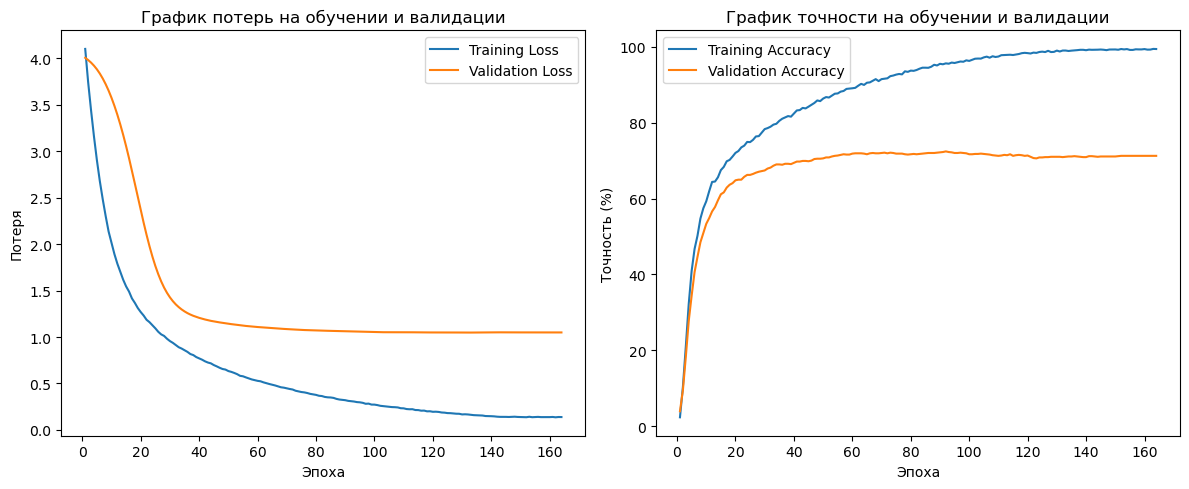

In [49]:
    # Построение кривых обучения
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Потеря')
    plt.title('График потерь на обучении и валидации')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность (%)')
    plt.title('График точности на обучении и валидации')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

class_params_prec=[]
class_params_recc=[]
class_params_f1=[]
class_params_acc=[]



# Функция для оценки модели на тестовых данных
def evaluate_model(model, test_loader, device):
    model.eval()  # Переключаем модель в режим оценки
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Отключаем градиенты
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Собираем все истинные метки и предсказания
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Вычисление метрик
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')  # Weighted для учета баланса классов
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    report = classification_report(all_labels, all_predictions, output_dict=True)
    # Вычисление точности по классам

    precision_per_class = precision_score(all_labels, all_predictions, average=None)  # None для метрик по классам

    recall_per_class = recall_score(all_labels, all_predictions, average=None)
    f1_per_class = f1_score(all_labels, all_predictions, average=None)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision (Weighted): {precision * 100:.2f}%")
    print(f"Recall (Weighted): {recall * 100:.2f}%")
    print(f"F1-Score (Weighted): {f1 * 100:.2f}%")

    for i, (p, r, f) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
        class_params_prec.append(p)
        class_params_recc.append(r)
        class_params_f1.append(f)

        print(f"Class {mapping_dict[i]}: Precision: {p:.2f}, Recall: {r:.2f}, F1-score: {f:.2f}")

evaluate_model(model,test_loader,'cuda')

Accuracy: 71.27%
Precision (Weighted): 71.48%
Recall (Weighted): 71.27%
F1-Score (Weighted): 71.03%
Class 2101: Precision: 0.68, Recall: 0.72, F1-score: 0.70
Class 2102: Precision: 0.74, Recall: 0.74, F1-score: 0.74
Class 2103: Precision: 0.81, Recall: 0.77, F1-score: 0.79
Class 2105: Precision: 0.77, Recall: 0.74, F1-score: 0.75
Class 2106: Precision: 0.76, Recall: 0.65, F1-score: 0.70
Class 2107: Precision: 0.90, Recall: 0.86, F1-score: 0.88
Class 2108: Precision: 0.77, Recall: 0.89, F1-score: 0.83
Class 2109: Precision: 0.91, Recall: 0.91, F1-score: 0.91
Class 2110: Precision: 0.86, Recall: 0.86, F1-score: 0.86
Class 2111: Precision: 0.78, Recall: 1.00, F1-score: 0.88
Class 2113: Precision: 0.61, Recall: 0.50, F1-score: 0.55
Class 2114: Precision: 0.60, Recall: 0.83, F1-score: 0.70
Class 2201: Precision: 0.76, Recall: 0.59, F1-score: 0.67
Class 2202: Precision: 0.89, Recall: 0.76, F1-score: 0.82
Class 2203: Precision: 0.80, Recall: 0.80, F1-score: 0.80
Class 2204: Precision: 0.81, R

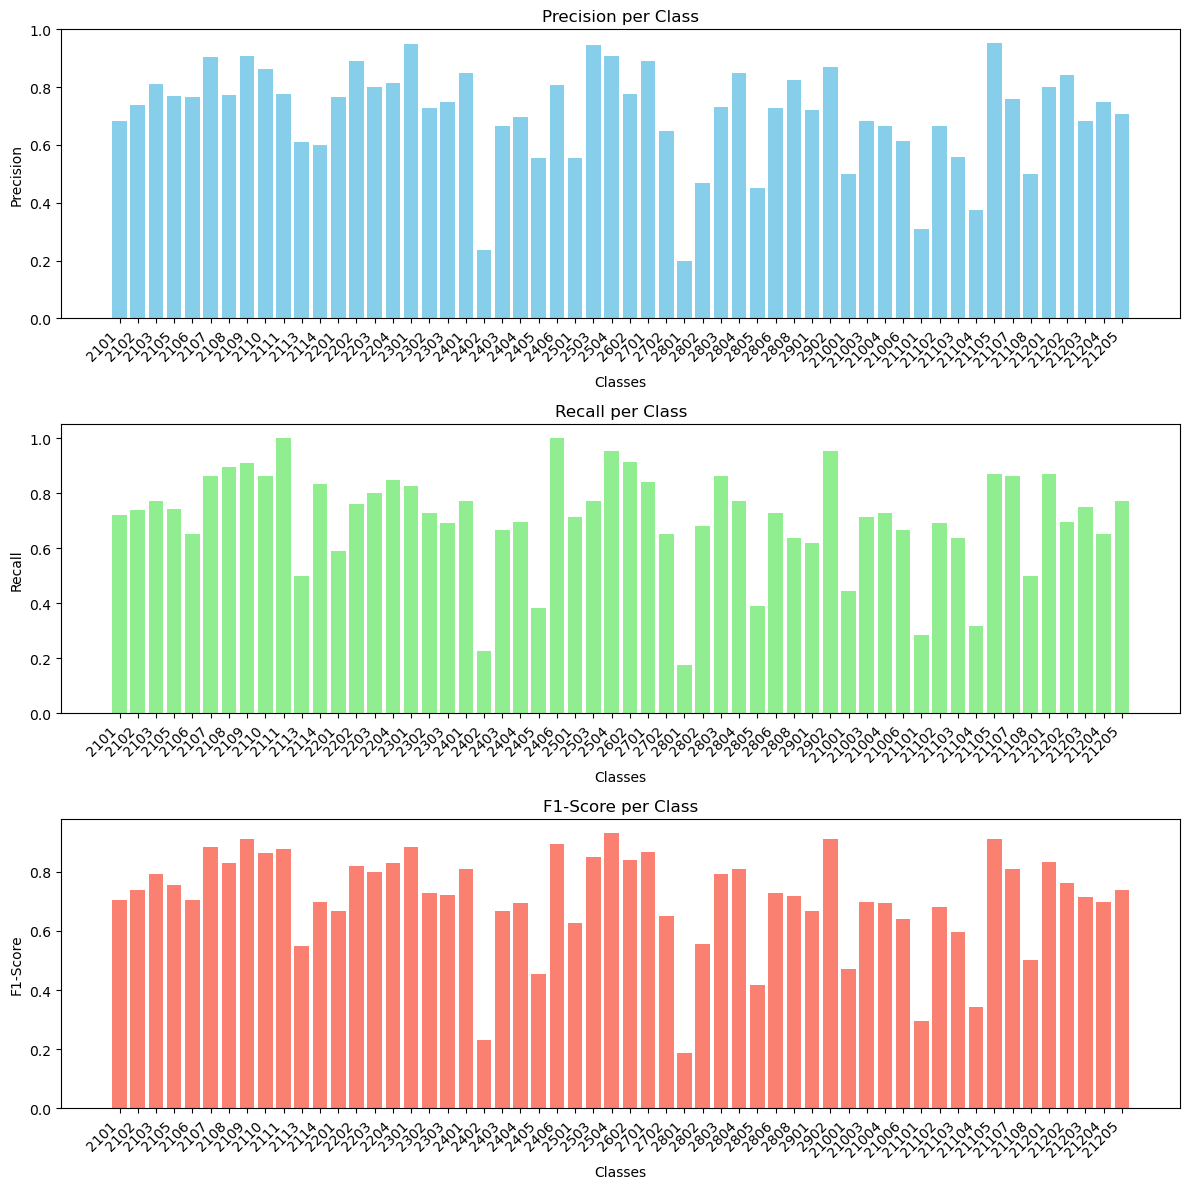

In [82]:
# Построение графиков для precision, recall и f1-score по классам

fig, ax = plt.subplots(3, 1, figsize=(12, 12))
class_labels=range(0,56)
class_labels_orig = [mapping_dict[i] for i in range(0,56)]
# Precision
ax[0].bar(class_labels, class_params_prec, color='skyblue')
ax[0].set_title('Precision per Class')
ax[0].set_ylabel('Precision')
ax[0].set_xlabel('Classes')
ax[0].set_xticks(class_labels)
ax[0].set_xticklabels(class_labels_orig, rotation=45, ha='right')

# Recall
ax[1].bar(class_labels, class_params_recc, color='lightgreen')
ax[1].set_title('Recall per Class')
ax[1].set_ylabel('Recall')
ax[1].set_xlabel('Classes')
ax[1].set_xticks(class_labels)
ax[1].set_xticklabels(class_labels_orig, rotation=45, ha='right')

# F1-score
ax[2].bar(class_labels, class_params_f1, color='salmon')
ax[2].set_title('F1-Score per Class')
ax[2].set_ylabel('F1-Score')
ax[2].set_xlabel('Classes')
ax[2].set_xticks(class_labels)
ax[2].set_xticklabels(class_labels_orig, rotation=45, ha='right')


#ax[3].bar(class_labels, class_params_acc, color='orange')
#ax[3].set_title('Accuracy per Class')
#ax[3].set_ylabel('Accuracy')
#ax[3].set_xlabel('Classes')
#ax[3].set_xticks(class_labels)
#ax[3].set_xticklabels(class_labels_orig, rotation=45, ha='right')

plt.tight_layout()
plt.show()